# A Python implementation of Assignment #3

As a reminder, here is assignment #3: Write a program to determine the center pixel of this CBCT image: https://github.com/jrkerns/MDA_workshop/blob/master/Data/CBCT.dcm?raw=true

There are multiple valid ways to accomplish finding the center of the phantom. I will show two strategies. 

Strategy #1: Sum the array along each axis and find the maximum value of each profile. The center of the phantom is where the phantom is widest (since it's a circle). The maximum value will be a surrogate for the phantom center.

Strategy #2: Convert the image to binary (black & white) and use a region-finding algorithm to "detect" the phantom. The region algorithm has several properties including the geometric center.

Since most of you are using MATLAB I've done this in Python so you can 1) see how to do it in a language you're not familiar with and 2) you have a template, not verbatim solution. Constructing an equivalent Matlab script shouldn't be difficult. The key functions to know are:
* [websave](http://www.mathworks.com/help/matlab/ref/websave.html?refresh=true) - Saves a URL to a local file. Note that you need 2014b or later. If you have an earlier version you can download the file manually and point to the file location, although this isn't reproducable across devices.
* [dicomread](http://www.mathworks.com/help/images/ref/dicomread.html) - Reads the image portion of a DICOM file.
* [regionprops](http://www.mathworks.com/help/images/ref/regionprops.html) - Finds connected "blobs" in a black & white image. Note that you'll have to [convert the DICOM image to black & white](http://www.mathworks.com/help/images/ref/im2bw.html).
* Basic array operations like [sum](http://www.mathworks.com/help/matlab/ref/sum.html), [mean](http://www.mathworks.com/help/matlab/ref/mean.html), and [max](http://www.mathworks.com/help/matlab/ref/max.html).

### Step 0: Retrieving & loading in the file

First, our imports:

In [172]:
%matplotlib inline

from urllib.request import urlretrieve  # a standard library function for downloading URLs: https://docs.python.org/3.4/library/urllib.request.html#urllib.request.urlretrieve

import matplotlib.pyplot as plt  # a plotting library similar to MATLAB's: http://matplotlib.org/
import numpy as np  # **the** scientific package for doing numerical computing in Python: http://www.numpy.org/
import dicom  # a DICOM-reading library: http://pydicom.readthedocs.org/en/latest/getting_started.html
from skimage import measure  # an image processing library: http://scikit-image.org/

Let's download and load the image array into Python.

In [173]:
url = 'https://github.com/jrkerns/MDA_workshop/blob/master/Data/CBCT.dcm?raw=true'
file_path, _ = urlretrieve(url)

We've now downloaded the file; the location is given by ``file_path`` (it's a temporary location).

In [174]:
file_path

'/tmp/tmplb8znpow'

In [175]:
dcm_dataset = dicom.read_file(file_path)

We've now read in the dicom file using the ``dicom`` library. This returns us the DICOM dataset. We can now view and access all DICOM tags:

In [176]:
dcm_dataset

(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20120626'
(0008, 0013) Instance Creation Time              TM: '184832'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.246.352.63.1.5401512045945835147.16659656049063764631
(0008, 0020) Study Date                          DA: '20120620'
(0008, 0021) Series Date                         DA: '20120626'
(0008, 0023) Content Date                        DA: '20120626'
(0008, 0030) Study Time                          TM: '124418'
(0008, 0031) Series Time                         TM: '184527.919'
(0008, 0033) Content Time                        TM: '184816.263'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) Manufacturer                        LO: 'Varian Medical Systems'
(0008, 0090) Referring Physic

We can access individual tags:

In [177]:
dcm_dataset.TableTopLongitudinalPosition

'539'

For our purposes, the important tag is Pixel Data, which is actually a raw string. The ``dicom`` library gives us a property that returns an array: ``pixel_array``

In [178]:
dcm_dataset.pixel_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

Let's plot it to make sure it's what we think it is:

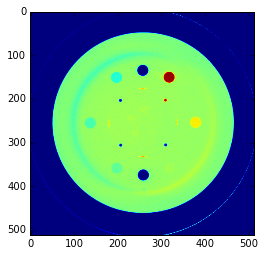

In [179]:
plt.imshow(dcm_dataset.pixel_array)

Okay, so the ``pixel_array`` attribute is what we think it is. For brevity, let's make a shorter variable name:

In [180]:
img = dcm_dataset.pixel_array

### Strategy #1: Using the sums of each axis

For this strategy we use the assumption that the phantom is circular and that the maximum value of the sum of a profile will be the midpoint. Apply the strategy to each axis (rows, columns) and viola!

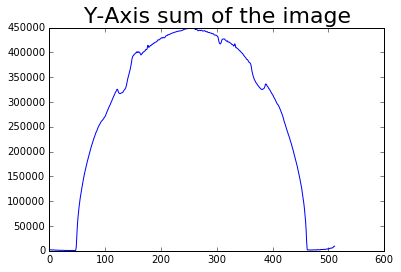

In [181]:
y_axis_sum = img.sum(axis=1)
plt.plot(y_axis_sum)
plt.title("Y-Axis sum of the image", fontsize=22)

So far so good. We've summed the image and as we would expect the values increase and the center of the phantom is probably where the maximum value of the profile is. Let's get that index.

In [182]:
y_axis_sum.max()  # the actual value

449252

In [183]:
y_axis_sum.argmax()  # the index

255

Perfect! we know the maximum y-value is at index 255 and we assume that is the y-center of the phantom. Let's go to the x-axis:

In [184]:
y_center = y_axis_sum.argmax()

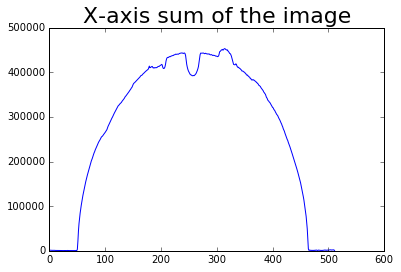

In [185]:
x_axis_sum = img.sum(axis=0)
plt.plot(x_axis_sum)
plt.title("X-axis sum of the image", fontsize=22)

Uh-oh! The maximum value isn't near the center. Looking back at the image it's clear now that the HU bubbles are throwing off our maximum value (the red circle on the image is the peak on the right; the blue circles make the dip in the center).

We can infer that the center is probably right in the middle of that dip. The easist way to get that value is to search for the *minimum* in the central area of the plot. Using the above plot, we can see that we should search between the indices of ~200 to ~300.

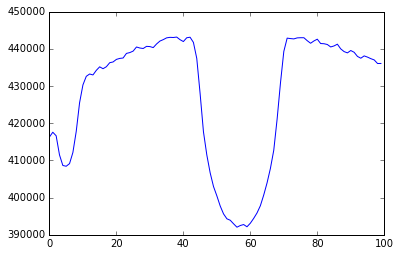

In [186]:
center_region = x_axis_sum[200:300]
plt.plot(center_region)

As a surrogate, let's search for the minimum value:

In [187]:
center_region.min()

392044

In [188]:
center_region.argmin()

56

56 is indeed the index in the middle of the dip. We can add that value to the left edge of the section we sampled to get the true x-center.

In [189]:
x_center = center_region.argmin() + 200

We've now determined the center of the image:

In [190]:
print('The image center is at x={}, y={}'.format(x_center, y_center))

The image center is at x=256, y=255


Looking at the image, this appears to be close to the real value. We did it!

### Strategy #2: Use a region-finding algorithm

Now, after seeing this strategy you may say "Cheater!", but that would be unfair. In real life, *any* strategy is valid, even if you aren't the one to come up with that algorithm. When possible, don't use your own code!

For this strategy, we'll use a region-finding algorithm. But first we have to convert the image to black and white. To do so, I'll set all the pixels < 100 to 0, and all other pixels to 1. 

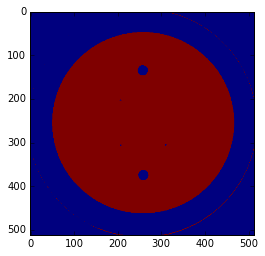

In [191]:
img[img < 100] = 0
img[img >= 100] = 1
plt.imshow(img)

``img`` is now a black and white image. We want to detect connected pixels, or "blobs". To do that we use a label algorithm: http://scikit-image.org/docs/dev/api/skimage.measure.html#label

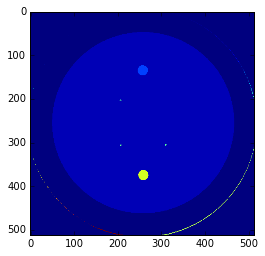

In [192]:
labeled_img = measure.label(img)
plt.imshow(labeled_img)

``labeled_img`` is an array where each connected region (blob) is set to the same value. E.g. all 0's are one connected blob, all 1's, all 2's, etc.

With this labeled array, we can now find region properties: http://scikit-image.org/docs/dev/api/skimage.measure.html#regionprops

In [193]:
regionprops = measure.regionprops(labeled_img)

``regionprops`` is a list holding attributes for each blob found. We can access each element and property. 

In [194]:
regionprops[1].area

17.0

In [195]:
regionprops[20].centroid

(121.0, 32.0)

What we need to do is find the blob that is the phantom. To do so we'll use one of the available properties: eccentricity. Eccentricity is the measure of how "circular" the blob is. 0 is a perfect circle; 1 is a line.

In [196]:
for prop in regionprops[:10]:  # print the first 20 eccentricities
    print(prop.eccentricity)

0.9993725796554175
0.9991698959997332
0.997871556110168
0.998966611871766
0.9970912219551324
0.09367924267683325
1.0
1.0
0
1.0


Hmmm, clearly eccentricity alone won't find us the phantom. We should also search for a very large blob, as the phantom is one of the largest blobs in the image.

In [197]:
for prop in regionprops[:10]:
    print("Ecc.: ", prop.eccentricity, "Area:", prop.area)

Ecc.:  0.9993725796554175 Area: 62.0
Ecc.:  0.9991698959997332 Area: 17.0
Ecc.:  0.997871556110168 Area: 11.0
Ecc.:  0.998966611871766 Area: 14.0
Ecc.:  0.9970912219551324 Area: 7.0
Ecc.:  0.09367924267683325 Area: 133931.0
Ecc.:  1.0 Area: 4.0
Ecc.:  1.0 Area: 5.0
Ecc.:  0 Area: 1.0
Ecc.:  1.0 Area: 24.0


The 5th element looks promising. Let's see if other properties match up to the phantom.

In [198]:
phantom_prop = regionprops[5]
print("Area:", phantom_prop.area)
print("Eccentricity:", phantom_prop.eccentricity)
print("Bounding Box:", phantom_prop.bbox)

Area: 133931.0
Eccentricity: 0.09367924267683325
Bounding Box: (48, 50, 462, 465)


So far so good! We can check whether the blob is the phantom by checking the bounding box. This is the extent of the blob in the format (ymin, xmin, ymax, xmax). Looking back at the phantom image this is indeed the edges of the phantom. We've found it! Now just find the center:

In [199]:
print("The phantom center is x={:.0f}, y={:.0f}".format(phantom_prop.centroid[1], phantom_prop.centroid[0]))

The phantom center is x=257, y=255


This is very close to our first algorithm and matches eyeball values, so we know we did it right. 

### There you have it: two ways to find the phantom center, both valid and both very different.